# Duboko učenje - laboratorijska vježba - generativni modeli - Generative adversarial networks (GAN)

Primarna namjena GAN-a je isto generiranje novih i uvjerljivih uzoraka, no princip rada je malo drugačiji od prethodna dva modela. GAN ne procjenjuje direktno parametre $p(\mathbf x)$ ili bilo koje druge distribucije, premda se njegovo treniranje može interpretirati kao estimacija $p(\mathbf x)$. Najvjerojatnije zahvaljujući tom drugačijem pristupu, GAN-ovi često generiraju vizualno najbolje uzorke u usporedbi sa VAE ili drugim generativnim mrežama.

GAN se sastoji od dvije zasebne mreže 

1. Generator (G) koji ima zadatak generirati uvjerljive uzorke
2. Diskriminator (D) koji ima zadatak prepoznati radi li se o pravom uzorku (iz skupa za treniranje) ili lažnom uzorku koji je generirao G

<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/GAN.svg" width="30%">
</div>
</center>

Te dvije mreže su protivnici (Adversaries), imaju dijametralno suprotstavljene ciljeve te se pokušavaju nadmudriti. To nadmetanje ih tjera da budu sve bolji u postizanju svog cilja i da se fokusiraju na sve bitne detalje ulaznih podataka. Očekivano, njihovo nadmetanje trebalo bi dovesti do toga da generator generira savršene uzorke koje diskriminator ne može razlikovati od uzoraka iz skupa za treniranje. Da bi generator postigao takav uspjeh nužno je da i diskriminator bude maksimalno dobar u svom zadatku.

Generator na svojem izlazu generira uzorke za neki slučajni ulazni vektor koji prati neku distribuciju. Ta slučajnost na ulazu omogućuje generatoru da uvijek generira nove uzorke. Pri tome nema nekih posebnih ograničenja na arhitekturu generatora, no poželjno je da se može trenirati backpropagation algoritmom. 

<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/G.svg" width="30%">
</div>
</center>

Diskriminator na svome izlazu treba estimirati pripadnost razredu stvarnih ili lažnih uzoraka za svaki ulazni vektor. Za razliku od generatora, ovdje je moguće koristiti učenje pod nadzorom jer se za svaki uzorak zna da li je došao iz skupa za treniranje ili od generatora. Radi jednostavnosti možemo izlaz diskriminatora ograničiti u rasponu $[0,1]$ i interpretirati kao vjerojatnost da je ulazni uzorak stvaran (iz skupa za treniranje).

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/D.svg" width="30%">
</div>
</center>
    

Gore opisani ciljevi diskriminatora i generatora mogu se formalno izraziti u sljedećoj funkciji cilja:

$\min_G \max_D V(D,G) = E_{ \mathbf x \sim p_{data}(\mathbf x) } [\log D( \mathbf x)] + E_{ \mathbf z  \sim p_{\mathbf z}(\mathbf z) } [\log(1 - D(G( \mathbf z)))]$

Prvi pribrojnik predstavlja očekivanje procjene log vjerojatnosti da su uzorci iz skupa za treniranje stvarni. Drugi pribrojnik predstavlja očekivanje procjene log vjerojatnosti da generirani uzorci nisu stvarni, tj. da su umjetni. Diskriminator ima za cilj maksimizirati oba pribrojnika, dok generator ima za cilj minimizirati drugi pribrojnik. Svaki pribrojnik funkcije cilja može se jednostavno procijeniti za jednu mini grupu te se može procijeniti gradijent s obzirom na prametre obiju mreža. 

Treniranje dviju mreža (G i D) može se provesti istovremeno ili se u jednoj iteraciji prvo može trenirati jedna mreža a zatim druga. Dodatno, neki autori preporučuju da se u nekoliko uzastopnih iteracija trenira jedna mreža, a nakon toga druga mreža samo jednu iteraciju.

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/GAN2.svg" width="50%">
</div>
</center>


Kod generiranja slika uspješnim se pokazao Deep Convolutional GAN (DCGAN) koji u skrivenim slojevima obiju mreža koristi konvolucijske slojeve. Za razliku od klasičnih konvolucijskih mreža, ovdje se ne koriste pooling slojevi nego se uzorkovanje provodi pomoću konvolucijskih slojeva koji imaju posmak veći od 1. Autori mreže preporučuju korištenje Batch normalizacije u svim slojevima osim u izlaznom sloju generatora te ulaznom i izlaznom sloju diskriminatora. Korištenje Leaky ReLU aktivacijskih funkcija u svim slojevima osim u izlaznim je još jedna specifičnost DCGAN-a kao i eliminacija potpuno povezanih slojeva.

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/DCGAN.svg" width="50%">
</div>
</center>

### U sljedećih nekoliko blokova koda nalaze se inicijalizacijske postavke i gotove pomoćne funkcije

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def prepare_data_loaders(batch_size=32):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(64),
                                    torchvision.transforms.ToTensor()
                               ])), batch_size=batch_size)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./files', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.Resize(64),
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size)
    
    return train_loader, test_loader

### 5. Zadatak

Implementirajte DCGAN s generatorom i diskriminatorom. Arhitekura treba biti:
    
* Generator
    * Sloj 1 - Broj izlaznih kanala = 512, veličina jezgre = 4, veličina koraka = 1
    * Sloj 2 - Broj izlaznih kanala = 256, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 3 - Broj izlaznih kanala = 128, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 4 - Broj izlaznih kanala = 64, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 5 - Broj izlaznih kanala = 1, veličina jezgre = 4, veličina koraka = 2, padding = 1

* Diskriminator
    * Sloj 1 - Broj izlaznih konvolucija = 64, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 2 - Broj izlaznih konvolucija = 128, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 3 - Broj izlaznih konvolucija = 256, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 4 - Broj izlaznih konvolucija = 512, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 5 - Broj izlaznih konvolucija = 1, veličina jezgre = 4, veličina koraka = 1, padding = 0

Ulaz u generator $\mathbf z$ neka ima 100 elemenata prema normalnoj distribuciji $N(0,1)$. Ulazni podaci neka su MNIST brojevi skalirani na veličinu 64x64 te treniranje provedite kroz barem 20 epoha. U jednoj iteraciji provedite jednu optimizaciju generatora i jednu optimizaciju diskriminatora s po jednom mini grupom. Koristite tanh aktivacijsku funkciju za izlaz generatora i sigmoid aktivaciju za izlaz diskriminator, a za ostaje slojeve "propustljivi" ReLU sa "negative_slope" parametrom od 0.2. Batch noramlizacija (jedan od podzadataka) ide iza svakog sloja.

**Podzadaci:**

 1. Vizualizirajte rezultate generiranja 100 novih uzoraka iz slučajnih vektora $\mathbf z$. Usporedite rezultate s uzorcima generiranim pomoću VAE.
 2. Spremite težine istreniranog modela u datoteku "zad5_gan.th" i uploadajte tu datoteku na Moodle.
 3. Na Moodle predajte vizualizaciju 1. podzadatka.
 4. Odgovorite na sljedeća pitanja **u bilježnici**. Bilježnicu na kraju predajte na Moodle.


Koristite sljedeći predložak:

**NAPOMENA**: Osim nadopunjavanja koda koji nedostaje, predložak se treba prilagođavati prema potrebi, a može i prema vlastitim preferencijama. Stoga **budite oprezni s tvrdnjama da vam neki dio koda ne radi!**

**Pitanje:**
    
U jednoj iteraciji provedite treniranje diskriminatora sa dvaje minigrupe a generatora sa jednom minigrupom. Ponovite isti postupak samo zamijenite mjesta generatora i diskriminatora. Vizualizirajte generirane uzorke i komentirajte retzultate.

**Odgovor:**

U trenutnoj konfiguraciji razlika je neprimjetna. Razlog tomu jest što je mini-batch metoda kompromis između stohastičkog i grupnog spusta, te veličina mini-batch grupe diktira kompromis između preciznosti gradijenta i broj koraka u spustu. Zbog toga, dvostruko povećanje veličine mini-batch grupe neće znatno utjecati na rezultate jer ne mijenja značajno preciznost niti broj koraka. Promjenu veličine mini-batch grupe treba upariti s varijacijom stope učenja.

**Pitanje:**

Isključite batch normalizaciju u obje mreže. Komentirajte rezultate.

**Odgovor:**

Prema radu na kojem je zasnovan DCGAN, svrha batch normalizacije je da olakša protok gradijenta tokom učenja. Općenito, batch normalizacija se koristi da poboljša stabilnost i time omogući brže i veće stope učenja. Ako isključimo batch normalizaciju, gradijenti se teže uče i ažuriraju pa se gradijenti brzo umanje na neučinkovitu razinu, a gubitak ostaje visok (oko 300-400).

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_size=100):
        super(Generator, self).__init__()
        self.latent_size = latent_size

        # Ulaz je latentni slučajni vektor z veličine 100
        # Izlaz je slika dimenzija 1 x 64 x 64 (Channel x Height x Width)

        self.conv1 = nn.ConvTranspose2d(in_channels=self.latent_size, out_channels=512, kernel_size=4, stride=1, padding=0)
        self.conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64,  kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.ConvTranspose2d(in_channels=64,  out_channels=1,   kernel_size=4, stride=2, padding=1)

        self.batchNorm1 = nn.BatchNorm2d(512)
        self.batchNorm2 = nn.BatchNorm2d(256)
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.batchNorm4 = nn.BatchNorm2d(64)

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Batch normalizacija u svim slojevima osim u izlaznom sloju
        # Leaky ReLU aktivacijska funkcija u svim slojevima osim u izlaznom

        # Layer 1
        # Ulaz:  z (100)
        # Izlaz: 512 x 4 x 4
        out = self.conv1(x)
        out = self.batchNorm1(out)
        out = self.lrelu(out)

        # Layer 2
        # Ulaz:  512 x 4 x 4
        # Izlaz: 256 x 8 x 8
        out = self.conv2(out)
        out = self.batchNorm2(out)
        out = self.lrelu(out)

        # Layer 3
        # Ulaz:  256 x 8  x 8
        # Izlaz: 128 x 16 x 16
        out = self.conv3(out)
        out = self.batchNorm3(out)
        out = self.lrelu(out)

        # Layer 4
        # Ulaz:  128 x 16 x 16
        # Izlaz: 64 x 32 x 32
        out = self.conv4(out)
        out = self.batchNorm4(out)
        out = self.lrelu(out)

        # Layer 5
        # Ulaz:  64 x 32 x 32
        # Izlaz: 1  x 64 x 64
        out = self.conv5(out)
        out = self.tanh(out)
        
        return out

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Ulaz je slika dimenzija 1 x 64 x 64 (Channel x Height x Width)
        # Izlaz je skalar

        self.conv1 = nn.Conv2d(in_channels=1,   out_channels=64,  kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64,  out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1,   kernel_size=4, stride=1, padding=0)

        self.batchNorm2 = nn.BatchNorm2d(128)
        self.batchNorm3 = nn.BatchNorm2d(256)
        self.batchNorm4 = nn.BatchNorm2d(512)

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Batch normalizacija u svim slojevima osim u ulaznom i izlaznom sloju
        # Leaky ReLU aktivacijska funkcija u svim slojevima osim u izlaznom
       
        # Layer 1
        # Ulaz:  1  x 64 x 64
        # Izlaz: 64 x 32 x 32
        out = self.conv1(x)
        out = self.lrelu(out)

        # Layer 2
        # Ulaz:  64  x 32 x 32
        # Izlaz: 128 x 16 x 16
        out = self.conv2(out)
        out = self.batchNorm2(out)
        out = self.lrelu(out)

        # Layer 3
        # Ulaz:  128 x 16 x 16
        # Izlaz: 256 x 8  x 8
        out = self.conv3(out)
        out = self.batchNorm3(out)
        out = self.lrelu(out)

        # Layer 4
        # Ulaz:  256 x 8 x 8
        # Izlaz: 512 x 4 x 4
        out = self.conv4(out)
        out = self.batchNorm4(out)
        out = self.lrelu(out)

        # Layer 5
        # Ulaz:  512 x 4 x 4
        # Izlaz: 1 x 1 x 1
        out = self.conv5(out)
        out = self.sigmoid(out)

        return out.squeeze()

In [22]:
dmodel = Discriminator()
gmodel = Generator()

In [23]:
def train(gmodel: Generator, dmodel: Discriminator, n_epochs=10, log_epochs=1, batch_size=32, learning_rate=1e-3, device='cpu'):
    train_loader, test_loader = prepare_data_loaders(batch_size=batch_size)
    
    gmodel = gmodel.to(device)
    dmodel = dmodel.to(device)
    
    gmodel.train()
    dmodel.train()
    
    criterion = nn.BCELoss()
    
    g_optim = optim.Adam(gmodel.parameters(), lr=learning_rate)
    d_optim = optim.Adam(dmodel.parameters(), lr=learning_rate)
    
    for epoch_idx in range(0, n_epochs):
        
        g_loss, d_loss = 0, 0
        
        for image_data, _ in tqdm.tqdm(train_loader):
            # discriminator update
            dmodel.zero_grad()
            
            # real data pass
            image_data = image_data.to(device) # Dohvati prave slike
            
            batch_size = image_data.shape[0]  # Izracunaj velicinu mini-batch grupe
            labels = torch.ones(batch_size, device=device).float() # Postavi da su svi primjerci '1' odnosno iz pravog data seta
            
            d_output = dmodel(image_data).view(-1)  # izlaz d (pravi) # Izmijenjeno: dodan argument i view(-1)
            d_err_real = criterion(d_output, labels) # greska (pravi) # Izmijenjeno: dodani argumenti
            d_err_real.backward()
            d_loss += d_err_real.item() / batch_size


            
            # fake data pass (generiranje laznih slika iz generatora)
            # Sampliraj 'z'
            noise = torch.randn(batch_size, 100, 1, 1, device=device) # Izmijenjeno: dodan argument 'z' tj 100
            fake_image_data = gmodel(noise) # generiraj sliku iz 'z'  # Izmijenjeno: dodan argument
            labels = torch.zeros(batch_size, device=device).float() # Postavi da su svi primjerci '0' odnosno generirani/lažni
            
            # Dohvati izlaz d (lažan)
            d_output = dmodel(fake_image_data.detach()).view(-1)      # Izmijenjeno: dodan argument i view(-1)
            d_error_fake = criterion(d_output, labels) #greska (lazan)# Izmijenjeno: dodani argumenti
            d_error_fake.backward()
            d_loss += d_error_fake.item() / batch_size
    
            d_optim.step() # Azuziraj tezine na diskriminatoru

            # generator update
            gmodel.zero_grad()
            
            # Dohvati neispravno klasificirane primjere tako da se isti lazan dataset iskoristi, ali komplementarne labele
            labels = torch.ones(batch_size, device=device).float()    # Izmijenjeno: dodan float()
            d_output = dmodel(fake_image_data).view(-1)               # Izmijenjeno: dodan argument i view(-1)
            g_error = criterion(d_output, labels)                     # Izmijenjeno: dodani argumenti
            g_error.backward()
            g_loss += g_error.item() / batch_size 
            g_optim.step() # Azuziraj tezine na generatoru

            
        if (epoch_idx + 1) % log_epochs == 0:
            print(f"[{epoch_idx+1}/{n_epochs}]: d_loss = {d_loss:.5f} g_loss {g_loss:.5f}")
            
    gmodel.eval()
    dmodel.eval()
    
    return gmodel, dmodel

In [24]:
gmodel, dmodel = train(gmodel, dmodel, n_epochs=20, batch_size=128, device='cuda')

100%|██████████| 469/469 [01:36<00:00,  4.87it/s]


[1/20]: d_loss = 0.90046 g_loss 30.13555


100%|██████████| 469/469 [01:30<00:00,  5.19it/s]


[2/20]: d_loss = 0.84045 g_loss 29.61162


100%|██████████| 469/469 [01:31<00:00,  5.11it/s]


[3/20]: d_loss = 0.00404 g_loss 31.40162


100%|██████████| 469/469 [01:32<00:00,  5.10it/s]


[4/20]: d_loss = 0.19556 g_loss 40.58418


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


[5/20]: d_loss = 0.35126 g_loss 44.79165


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


[6/20]: d_loss = 0.57375 g_loss 29.61853


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


[7/20]: d_loss = 0.73530 g_loss 27.39155


100%|██████████| 469/469 [01:32<00:00,  5.09it/s]


[8/20]: d_loss = 0.34193 g_loss 27.86872


100%|██████████| 469/469 [01:32<00:00,  5.09it/s]


[9/20]: d_loss = 0.32115 g_loss 27.81749


100%|██████████| 469/469 [01:32<00:00,  5.07it/s]


[10/20]: d_loss = 0.61585 g_loss 28.22123


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


[11/20]: d_loss = 0.45790 g_loss 25.68553


100%|██████████| 469/469 [01:32<00:00,  5.09it/s]


[12/20]: d_loss = 0.77694 g_loss 23.39704


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


[13/20]: d_loss = 1.34805 g_loss 20.07164


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


[14/20]: d_loss = 1.09033 g_loss 19.84747


100%|██████████| 469/469 [01:32<00:00,  5.09it/s]


[15/20]: d_loss = 0.94292 g_loss 21.14437


100%|██████████| 469/469 [01:32<00:00,  5.07it/s]


[16/20]: d_loss = 1.17017 g_loss 20.32882


100%|██████████| 469/469 [01:32<00:00,  5.09it/s]


[17/20]: d_loss = 0.84485 g_loss 26.93520


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


[18/20]: d_loss = 0.80459 g_loss 22.54119


100%|██████████| 469/469 [01:32<00:00,  5.07it/s]


[19/20]: d_loss = 0.43512 g_loss 32.78998


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]

[20/20]: d_loss = 1.06571 g_loss 20.50582


In [25]:
random_sample = gmodel(torch.randn(100, 100, 1, 1).to('cuda')).view(100, 64, 64).data.cpu().numpy()

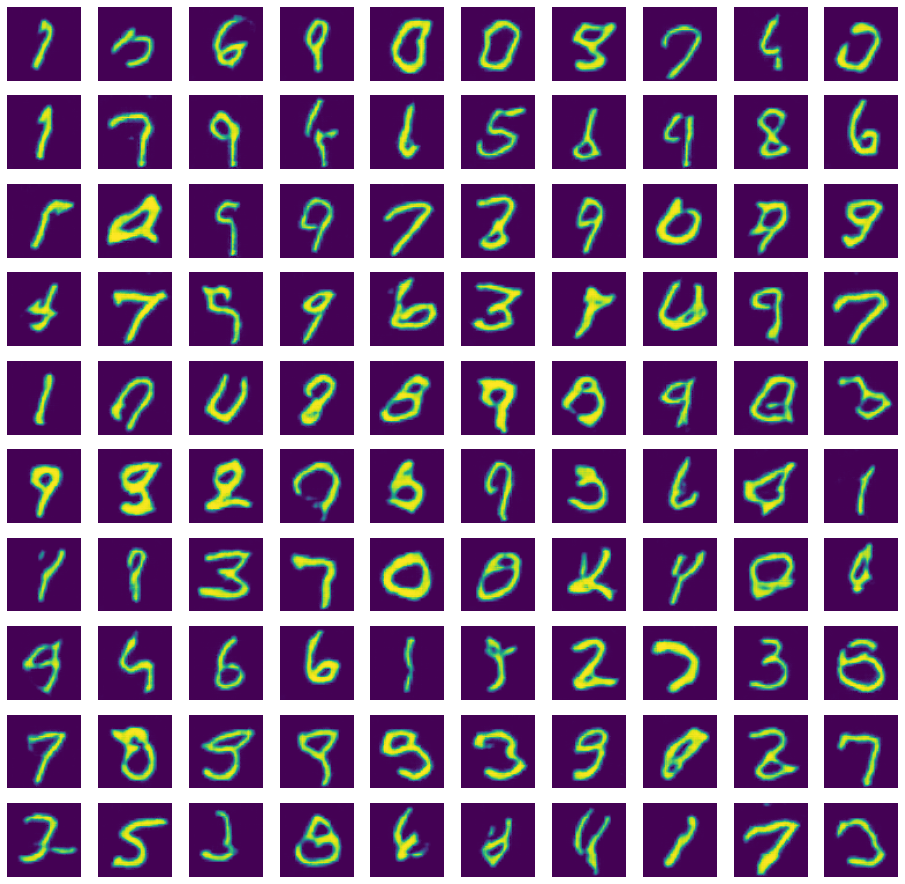

In [26]:
plt.figure(figsize=(16, 16))
for idx in range(0, 100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample[idx, ...])
    plt.clim(0, 1)
    plt.axis('off')

In [27]:
with open('zad5_gan.th', 'wb') as f:
    torch.save(gmodel.state_dict(), f)